# EXAMPLE: Finding the turning points and predicting motion from the conservation of energy with Python

Consider the potential
$$V(x) = \frac{a}{x} + b x^2 - c x^3,$$

with $a = 4~\rm{Jm}, \; b = 25 ~\mathrm{Jm}^{-2}, \;c = 8 ~\mathrm{Jm}^{-3}$ and $x>0$.

We will see how to use what we learned so far in the python crash course to:

* Find the turning points in different energy regions
* Plot the potential energy and turning points
* Plot the particle kinetic energy
 
## Recap: Equilibrium points
We repeat some of the operations from last week: defining the symbols and functions. Recall, `V` is the potential in the general form, and `Vp` is the potential with the values of `a`, `b` and `c` specified

In [31]:
import sympy as sy

x = sy.Symbol('x', positive=True, real=True)
a,b,c = sy.symbols('a, b, c', positive=True , real=True)
V = sy.Function('V')
V = a/x + b*x**2 - c*x**3
Vp = V.subs(a, 4).subs(b, 25).subs(c, 8)
Eq = sy.Eq(Vp.diff(x), 0)
Eq_points = sy.solve(Eq, x)
print(sy.N(Eq_points[0]), sy.N(Eq_points[1]))

2.06438923261828 0.469134342329583


In [13]:
d2Vdx2 = Vp.diff(x, 2)
for point in Eq_points:
    val = d2Vdx2.subs(x, point)
    print(sy.N(point), sy.N(val))

2.06438923261828 -48.1813663313549
0.469134342329583 104.963103136360


So, as before, we have an equilibrium point at 2.06 m which is unstable, and one at 0.47 m which is stable. Once again, we will use `sy.lambdify` to define a function potential which gives the potential at a given position `x`

In [14]:
potential = sy.lambdify([x], Vp)

---

# Turning points for different values of energy
Let's look at the numerical value of the potential at the stationary points

In [15]:
for point in Eq_points:
    print(sy.N(Vp.subs(x, point)))

38.0976829934267
13.2025150287882


With this information (and looking at the plot we produced last week) we can see there are four energy regions:

1. $E < 13.2~J$
2. $13.2~J < E < 38.1~J$
3. $E \approx 38.1~J$
4. $E > 38.1~J$

We'll now consider specific energy values which fall into these regions. 

---

### $E = 20 J$
This is energy region 2 listed above. To find the turning points we find the roots of $V(x)=20$. The exact expression for the turning point is quite awkward. Below, the `for` loop is converting the list of solutions `tp` into numbers.

In [16]:
tp = sy.solve(Vp-20, x, force=True)
tpn = []
for point in tp:
    tpn.append(sy.N(point))
print('Numerical solution:')
print(tpn)

Numerical solution:
[-0.876059897942905 - 1.813131947204e-28*I, 0.210940534133335 - 1.81313194720239e-28*I, 0.954010865340607 + 1.81313194720366e-28*I, 2.83610849846896 + 1.81313194720273e-28*I]


You can see here that each of the numerical solutions in `tpn` has a small imaginary component. This is due to numerical error, which we can confirm by looking at the imaginary part of the exact solutions `tp`.

In [17]:
for point in tp:
    print(sy.im(point))

0
0
0
0


Thus, we can just take the real part (using `sy.re`) of the values in `tp`, ignoring the imaginary part as a numerical error. We can also select only the positive values since we are asked to consider only $x>0$. We can do this with an `if` statement:

In [30]:
turning_points = []
for point in tp:
    r = sy.re(sy.N(point))
    if r > 0:
        turning_points.append(r)
print(turning_points)

[0.210940534133335, 0.954010865340607, 2.83610849846896]


We can then plot the potential $V$, the particle energy (using `hlines`) and the turning points

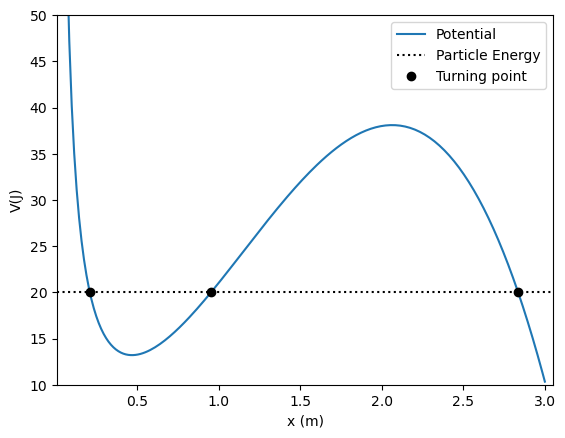

In [33]:
import matplotlib.pyplot as plt
import numpy as np

E1 = 20
xs = np.linspace(0.01, 3, 200)
plt.plot(xs, potential(xs), label='Potential')
plt.hlines(E1, 0.01, 3.05, colors='k',
           linestyles='dotted', label='Particle Energy')
plt.plot(np.array(turning_points[:]), potential(
         np.array(turning_points[:])), 'ko', label='Turning point')
plt.xlabel('x (m)')
plt.ylabel('V(J)')
plt.xlim(0.01, 3.05)
plt.ylim(10, 50)
plt.legend()
plt.show()

We can also plot the particle kinetic energy. Since the total energy, $E$ , is conserved, the kinetic energy $T$ of the particle is just $T=E-V$. We plot only the non-negative values since we require kinetic energy $T\geq 0$. The regions where $T< 0$ are called classically forbidden regions.

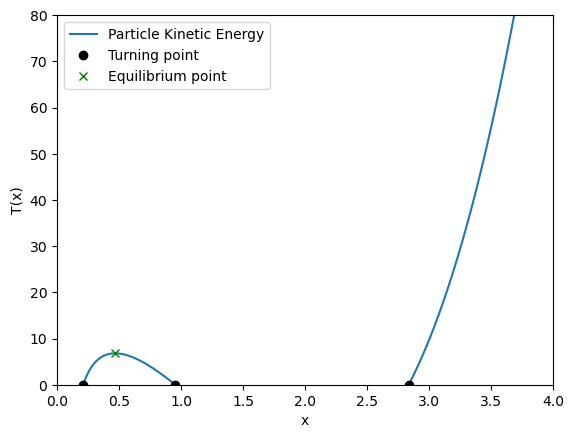

In [35]:
xs = np.linspace(0.1, 4, 200)
plt.ylim(0, 80)
plt.xlim(0, 4)
plt.plot(xs, E1 - potential(xs), label='Particle Kinetic Energy')
plt.plot(np.array(turning_points[:]), E1-potential(
         np.array(turning_points[:])), 'ko', label='Turning point')
plt.plot(Eq_points[1], E1-potential(Eq_points[1]),
         'gx', label='Equilibrium point')
plt.xlabel('x')
plt.ylabel('T(x)')
plt.legend()
plt.show()

From the two plots, one can see that the particle can move only in the regions where $0.21~\mathrm{m} \lessapprox x \lessapprox 0.95~\mathrm{m}$ or if $x \gtrapprox 2.84~\mathrm{m}$. In the former region, the kinetic energy, and thus the velocity, is 0 at the turning points while reaches its maximum at the equilibrium point. In the latter region, the kinetic energy, and thus the velocity, is 0 at the turning points and then increases monotonically.

---

## Other energy values
We now repeat the same process for other interesting energy values. One way of doing that would be to cut and paste the code used for $E=20J$ and change the value of $E$ each time. The resulting code would be difficult to follow and the process is prone to error. A better approach is to encapsulate the code above into functions that take the energy as an input argument. Then, for each value of $E$, one calls this set of functions. The code is much neater this way. Imagine I need to change the style of a line or the label of an axis for all the plots. If I defined functions, I only need to change it in the function, if I have multiple cut-and-pasted blocks of code, I'd need to change all occurrences.

We define 3 functions:

* `TurningPoints` takes the particle energy `E` and returns the numerical value of the positive, real solutions of $V(x)=E$.
* `PlotPotential` takes the particle energy `E`, the list of turning points `tpn` and optionally the `x` and `y` limits for the axes (if not specified it uses the default values given in the definition). It plots the potential, the particle energy and the turning points.
* `PlotKinetic` takes the particle energy `E` and the list of turning points `tpn`. It plots the kinetic energy, the equilibrium and turning points.

In [36]:
def TurningPoints(E):
    tp = sy.solve(Vp-E, x)
    tpn = []
    for point in tp:
        imag = sy.im(sy.N(point))
        real = sy.re(sy.N(point))
        if real > 1e-8 and abs(imag) < 1e-8:  # Choose only real and positive values
            tpn.append(real)
    return tpn

def PlotPotential(E, tpn, Xl=[0.01, 3.05], Yl=[10, 50]):
    xs = np.linspace(Xl[0], Xl[1], 200)
    plt.plot(xs, potential(xs), label='Potential')
    plt.hlines(E1, 0.01, 3.05, colors='k',
               linestyles='dotted', label='Particle Energy')
    plt.plot(np.array(tpn[:]), potential(
        np.array(tpn[:])), 'ko', label='Turning point')
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.xlim(Xl[0], Xl[1])
    plt.ylim(Yl[0], Yl[1])
    plt.legend()
    plt.show()

def PlotKinetic(E, tpn):
    xs = np.linspace(0.01, 4, 200)
    plt.ylim(0, 80)
    plt.xlim(0, 4)
    plt.plot(xs, E - potential(xs), label='Particle Kinetic Energy')
    plt.plot(np.array(tpn[:]), E-potential(np.array(tpn[:])),
             'ko', label='Turning point')
    plt.plot(Eq_points[0], E-potential(Eq_points[0]),
             'rx', label='Unstable stationary point')
    plt.plot(Eq_points[1], E-potential(Eq_points[1]),
             'gx', label='Stable stationary point')
    plt.xlabel('x')
    plt.ylabel('T(x)')
    plt.legend()
    plt.show()


---

Having defined these functions, we may now call them for different energy values as follows (click on the $\rangle$ symbol to expand each section)

### $E =38J$

Turning points:  [2.00000000000000, 0.106020578386384, 2.12739346352552]


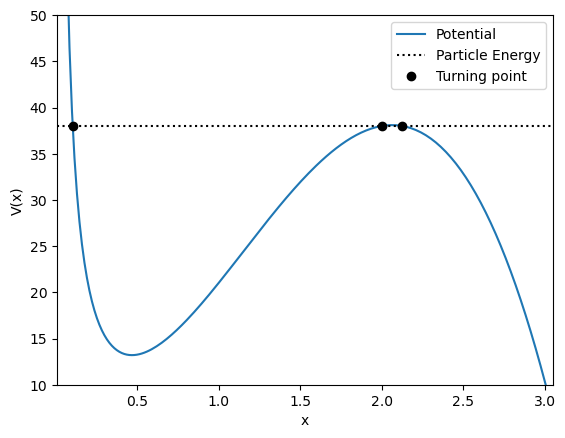

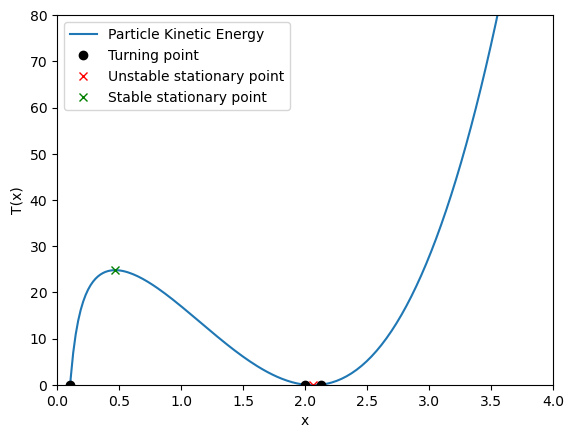

In [37]:
E1 = 38
tpre = TurningPoints(E1)
print('Turning points: ',tpre)
PlotPotential(E1, tpre)
PlotKinetic(E1, tpre)

$E = 38~J$ is slightly lower than the potential energy at the unstable equilibrium. From the plots, we see that this case is analogous to the $E=20~J$ case with a classically forbidden region about the unstable equilibrium $(2.0 ~m \lt x \lessapprox2.13 ~m)$.

---

### $E = 38.098~J$

Turning points:  [0.105741989590996]


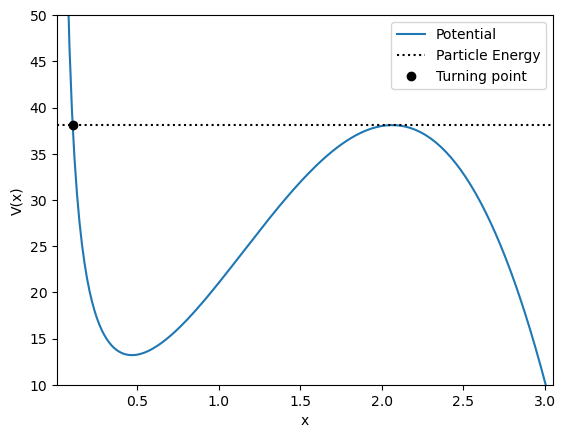

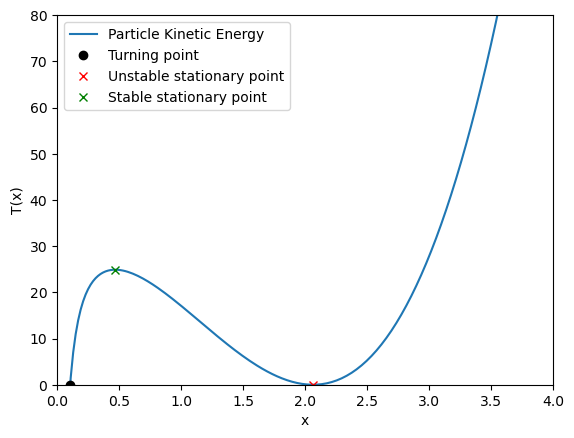

In [39]:
E1 = 38.098
tpre = TurningPoints(E1)
print('Turning points: ',tpre)
PlotPotential(E1, tpre)
PlotKinetic(E1, tpre)

$E = 38.098~J$ is slightly higher than the potential energy at the unstable equilibrium. From the plots we see that motion is allowed for any $x \gtrapprox 0.11~m$ . The kinetic energy (thus the velocity) increases up to the stable equilibrium point, then decreases towards zero close to the unstable equilibrium point and then increases monotonically.


---

### $E=45~J$

Turning points:  [0.0892728600008791]


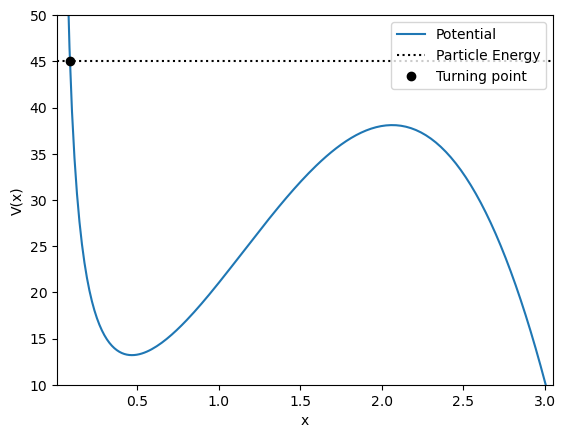

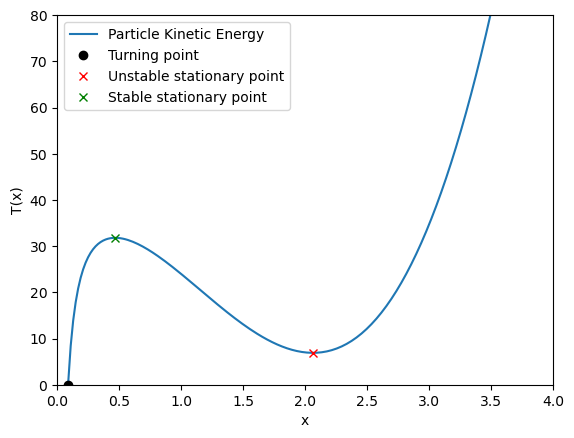

In [40]:
E1 = 45
tpre = TurningPoints(E1)
print('Turning points: ',tpre)
PlotPotential(E1, tpre)
PlotKinetic(E1, tpre)

$E=45~J$ is higher than the potential energy at the unstable equilibrium. From the plots we see that motion is allowed for any $x \gtrapprox 0.09~ m$. The kinetic energy (thus the velocity) increases up to the stable equilibrium point, then decreases up to the unstable equilibrium point and then increases monotonically.

---

### $E=12~J$

Turning points:  [2.97445839981429]


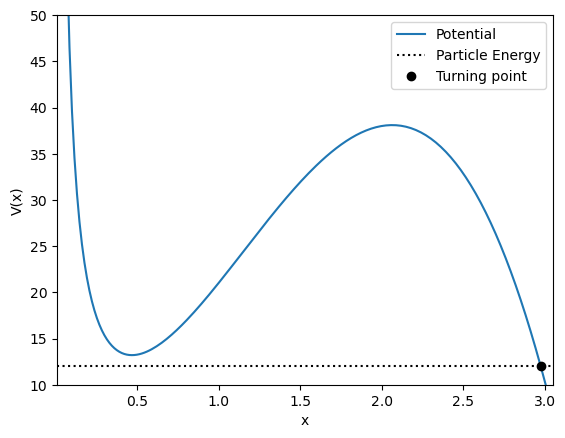

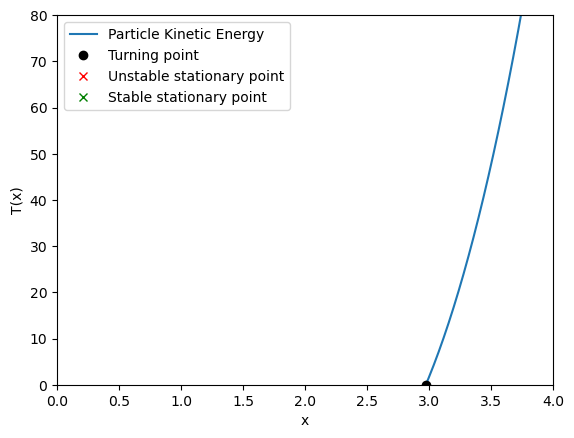

In [41]:
E1 = 12
tpre = TurningPoints(E1)
print('Turning points: ',tpre)
PlotPotential(E1, tpre)
PlotKinetic(E1, tpre)

From the plots we see that motion is allowed for any $x \gtrapprox 2.97~ m$. The kinetic energy (thus the velocity) increases monotonically.